## Loading files and Environment

In [2]:
#%conda env export > environment.yaml

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import sys
import pathlib
import sklearn
import numpy
import nltk
import wordcloud
import gensim
import scipy.stats as stats
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.datasets import load_iris
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import stopwords
from collections import Counter
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

In [4]:
# Get current directory
current_dir = os.getcwd()
# Get parent directory
parent_dir = os.path.join(current_dir, '..')
# Append parent directory to sys.path
sys.path.append(parent_dir)
from src import data_cleaning as dc

In [5]:
cwd = pathlib.Path.cwd().parent
training_file_path = cwd.joinpath("datasets/EuansGuideData.xlsx")
test_file_path = cwd.joinpath("datasets/GoogleReviews")
print('path:', training_file_path)
print('path:', test_file_path)

path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/EuansGuideData.xlsx
path: /Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/GoogleReviews


In [6]:
all_file_names = glob.glob(str(test_file_path) + "/*.csv")
google_df = [pd.read_csv(file_name, index_col=None, header=0) for file_name in all_file_names]
test_data = pd.concat(google_df, axis=0, ignore_index=True)

## Cleaning & Preprocessing

In [7]:
training_data = pd.read_excel(training_file_path)
clean_train_df = dc.clean_and_select(training_data, ["Aspect", "Rating", "Review", "Venue"])
clean_test_df = dc.clean_and_select(test_data, ["Name","Review Rate", "Review Text"])

/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/notebooks/../src/data_cleaning.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Text"] = df["Text"].apply(lambda x: x.replace("\n", ' '))
/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/notebooks/../src/data_cleaning.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_aspects["Venue"] = selected_aspects["Venue"].apply(lambda x: get_venue_name(x))
/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Rev

In [8]:
clean_train_df.head()

,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label
1,Transport & Parking,5.0,"There is disabled parking close to the doors, ...",dobbies garden centre perth,2,positive,1.0
7,Transport & Parking,4.5,"A ten minute walk from the luas, not much near...",bow lane dublin,1,positive,1.0
14,Toilets,4.5,"I did not use the toilets, but if you ring the...",jorvik viking centre york,1,positive,1.0
17,Transport & Parking,4.5,"It's situated on the high street, which has a ...",potter about burntisland,3,positive,1.0
19,Toilets,4.5,Clean and spacious with a grab rail on one sid...,potter about burntisland,3,positive,1.0


In [9]:
clean_test_df.head()

,Name,Sentiment,Text,Label
0,Ellis,positive,"It was a bit quite when we went in, but don’t ...",1
1,Ellis,positive,Nice cozy place which serves very tasty burger...,1
2,Ellis,positive,Really nice place. One of my favourite burger ...,1
3,Ellis,negative,The Service was quite good but the burgers we ...,0
4,Ellis,positive,I had a very nice experience! The staff were r...,1


## Exploratory Data Analysis

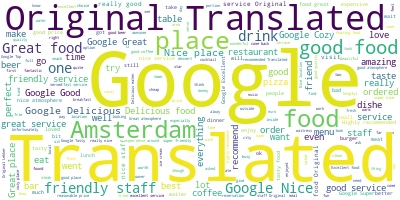

In [10]:
wordcloud = WordCloud(background_color='white', max_words=1000, contour_width=3, contour_color='steeleblue')

clustered_reviews_train = ','.join(list(clean_train_df['Text'].values))
clustered_reviews_test = ','.join(list(clean_test_df['Text'].values))
wordcloud.generate(clustered_reviews_train)
wordcloud.generate(clustered_reviews_test)
wordcloud.to_image()
wordcloud.to_image()

<AxesSubplot: title={'center': "Overview of Aspects in Euan's Guide data"}, xlabel='Aspect Types', ylabel='Amount of aspects'>

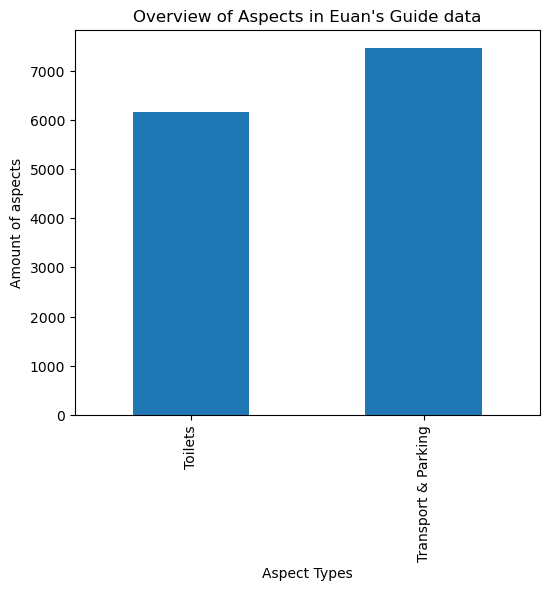

In [11]:
amount_per_aspect = clean_train_df.groupby(['Aspect']).count()
amount_per_aspect = amount_per_aspect['Text']
amount_per_aspect.plot(kind='bar', title="Overview of Aspects in Euan's Guide data", ylabel='Amount of aspects', xlabel='Aspect Types', figsize=(6,5))

<AxesSubplot: title={'center': "Overview of Sentiments in Euan's Guide data"}, xlabel='Sentiment Types', ylabel='Amount of Each Sentiment'>

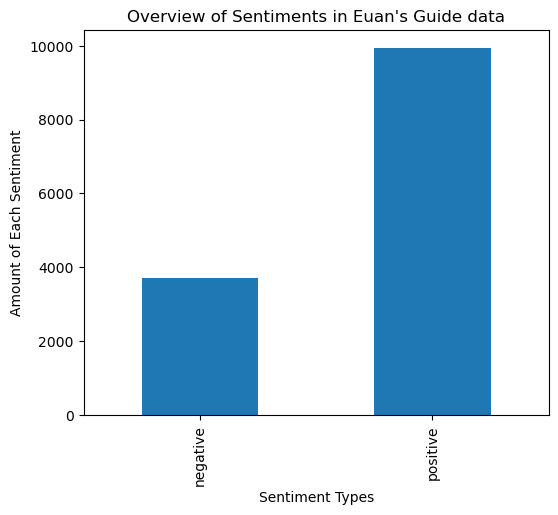

In [12]:
amount_per_sentiment = clean_train_df.groupby(['Sentiment']).count()
amount_per_sentiment = amount_per_sentiment['Text']
amount_per_sentiment.plot(kind='bar', title="Overview of Sentiments in Euan's Guide data", ylabel='Amount of Each Sentiment', xlabel='Sentiment Types', figsize=(6,5))

## Aspect Classification

### Pipeline setup

In [13]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics.pairwise import cosine_similarity



In [14]:
vectorizer = CountVectorizer()
n = round(len(clean_train_df))
euans_reviews = clean_train_df.Text.values.tolist()
google_reviews = clean_test_df[:n].Text.values.tolist()
euans_labels = clean_train_df.Aspect.values.tolist()


In [15]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression())
    ]))
])

In [16]:
parameters = {
    'vectorizer__max_df': (0.5, 0.75, 1.0),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),
    'clf__voting': ('soft', 'hard'),
    'clf__nb__alpha': (0.5, 1),
    'clf__lr__C': (0.1, 1, 10),
}

In [17]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, cv=5, n_jobs=5, verbose=1)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(euans_reviews, euans_labels, test_size=0.2, random_state=42)

In [19]:
import random

google_sample = random.sample(google_reviews, len(y_val))

In [20]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('clf',
                                        VotingClassifier(estimators=[('nb',
                                                                      MultinomialNB()),
                                                                     ('lr',
                                                                      LogisticRegression())]))]),
             n_jobs=5,
             param_grid={'clf__lr__C': (0.1, 1, 10), 'clf__nb__alpha': (0.5, 1),
                         'clf__voting': ('soft', 'hard'),
                         'vectorizer__max_df': (0.5, 0.75, 1.0),
                         'vectorizer__ngram_range': ((1, 1), (1, 2))},
             verbose=1)

In [21]:
y_pred = grid_search.predict(X_val)

In [22]:
google_pred = grid_search.predict(google_sample)

In [23]:
pos_labels = ['Toilets', 'Transport & Parking']

### Evaluation Metrics

In [24]:
valuation_report = classification_report(y_val, y_pred, labels=pos_labels)
evaluation_report = classification_report(y_val, google_pred, labels=pos_labels)
print("Euan's Guide Evaluation Report\n",valuation_report)
print("Google Reviews Evaluation Report\n",evaluation_report)
# save report as a text file
with open('../Results/google_aspect_classification_report.txt', 'w') as f:
    f.write(evaluation_report)
    
with open('../Results/euans_aspect_classification_report.txt', 'w') as f:
    f.write(valuation_report)

# # convert text file to PNG image
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/google_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/google_aspect_classification_report.png')

with open('../Results/euans_aspect_classification_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/euans_aspect_classification_report.png')


Euan's Guide Evaluation Report
                      precision    recall  f1-score   support

            Toilets       0.99      0.99      0.99      1218
Transport & Parking       0.99      0.99      0.99      1508

           accuracy                           0.99      2726
          macro avg       0.99      0.99      0.99      2726
       weighted avg       0.99      0.99      0.99      2726

Google Reviews Evaluation Report
                      precision    recall  f1-score   support

            Toilets       0.45      0.60      0.52      1218
Transport & Parking       0.56      0.40      0.47      1508

           accuracy                           0.49      2726
          macro avg       0.50      0.50      0.49      2726
       weighted avg       0.51      0.49      0.49      2726



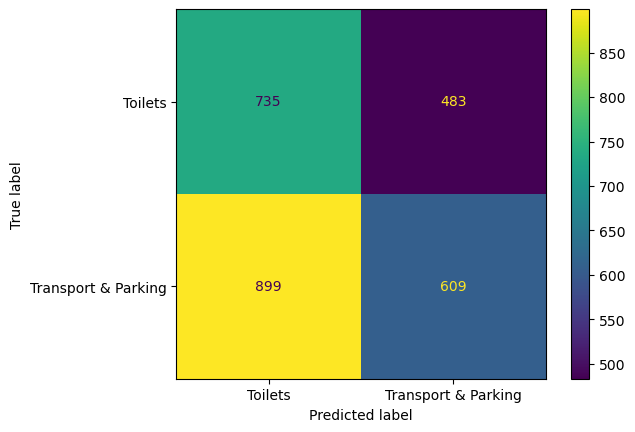

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, google_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pos_labels)

display.plot()

## Sentiment Analysis

In [26]:
sentiment_labels = clean_train_df.Sentiment.values.tolist()
X2_train, X2_val, y2_train, y2_val = train_test_split(euans_reviews, sentiment_labels, test_size=0.2, random_state=42)

pipeline2 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('clf', VotingClassifier([
        ('nb', MultinomialNB()),
        ('svm', SVC())
    ]))
])

In [27]:
sentiment_params = {
    'vectorizer__max_features': [1000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'clf__voting': ['hard', 'soft'],
    'clf__weights': [[0.5, 0.5], [0.7, 0.3]],
    'clf__estimators': [
        [('nb', MultinomialNB(alpha=0.5)), ('svm', SVC(kernel='linear', C=1.0))],
        [('nb', MultinomialNB(alpha=1.0)), ('svm', SVC(kernel='rbf', C=10.0, gamma=0.1))]
    ]
}

In [28]:
grid_search2 = GridSearchCV(estimator=pipeline2, param_grid=sentiment_params, cv=5, n_jobs=5, verbose=1)
grid_search2.fit(X2_train, y2_train)
y2_pred = grid_search2.predict(X2_val)
google2_pred = grid_search2.predict(google_sample)
euans_report = classification_report(y2_val, y2_pred)
google_report = classification_report(google2_pred, y2_pred)

print('Euans Report\n', euans_report)
print('Google Report\n', google_report)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/pipeline.py", line 722, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/sklearn/base.py", line 649, in score
    return accuracy_score(y, s

Euans Report
               precision    recall  f1-score   support

    negative       0.69      0.57      0.63       709
    positive       0.86      0.91      0.88      2017

    accuracy                           0.82      2726
   macro avg       0.78      0.74      0.76      2726
weighted avg       0.82      0.82      0.82      2726

Google Report
               precision    recall  f1-score   support

    negative       0.12      0.19      0.15       390
    positive       0.85      0.78      0.82      2336

    accuracy                           0.70      2726
   macro avg       0.49      0.48      0.48      2726
weighted avg       0.75      0.70      0.72      2726



In [29]:
# save report as a text file
with open('../Results/google_sentiment_analysis_report.txt', 'w') as f:
    f.write(google_report)
    
with open('../Results/euans_sentiment_analysis_report.txt', 'w') as f:
    f.write(euans_report)

# # convert text file to PNG image optimise this as you repeat this code.
img = Image.new('RGB', (800, 800), color='white')
font = ImageFont.truetype('../media/Fonts/Roboto/Roboto-Black.ttf', 20)
draw = ImageDraw.Draw(img)

with open('../Results/euans_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/euans_sentiment_analysis_report.png')

with open('../Results/google_sentiment_analysis_report.txt', 'r') as f:
    y = 0
    for line in f.readlines():
        draw.text((10, y), line, fill='black', font=font)
        y += 20

img.save('../Results/google_sentiment_analysis_report.png')


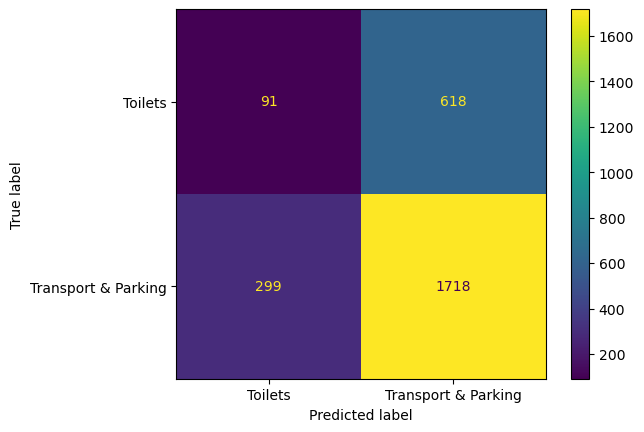

In [30]:
cm2 = confusion_matrix(y2_val, google2_pred)

display2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=pos_labels)

display2.plot()

## Opinion Summarisation

Moved this part to Google Colab https://colab.research.google.com/drive/1NVzQ3vS6oaQ7EPFzzij1XbjDQT0QpOBO?usp=sharing

In [31]:
#clean_test_df.to_csv('/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/google_reviews.csv', index=False)
#clean_train_df.to_csv("/Users/mylene/BachelorsProject/Venue-Accessibility-Google-Reviews/datasets/euans_reviews.csv", index=False)

In [32]:
# from transformers import pipeline
# from textblob import TextBlob
# summariser = pipeline('summarization', model='distilbert-base-uncased')

# """
# We want the review text per venue, aspect and sentiment.
# """
# # Possibly vader could look at identifying the sentiment correctly.
# # [['Venue', 'Aspect', 'Sentiment', 'Text']]


# summaries = summariser(euans_reviews, max_length=50, min_length=10)

# reviews_per_venue = clean_train_df['summary'] = [summary['Summarised Review'] for summary in summaries]
# reviews_per_venue.head()


# # Group all reviews per venue
# # generate a summary of the sentiment and aspects for that venue.

## Lex Rank implementation

In [33]:
import sumy
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

long_reviews = clean_train_df[clean_train_df['SentenceCount'] > 1]
long_reviews


,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label
1,Transport & Parking,5.0,"There is disabled parking close to the doors, ...",dobbies garden centre perth,2,positive,1.0
17,Transport & Parking,4.5,"It's situated on the high street, which has a ...",potter about burntisland,3,positive,1.0
19,Toilets,4.5,Clean and spacious with a grab rail on one sid...,potter about burntisland,3,positive,1.0
34,Transport & Parking,5.0,There is a large car park with a good number o...,the peak at stirling sports village stirling,4,positive,1.0
36,Toilets,4.5,There are quite a few accessible toilets thro...,the peak at stirling sports village stirling,6,positive,1.0
...,...,...,...,...,...,...,...
56578,Toilets,3.0,I didnt find any accessible toilets. On the gr...,hotel el tope puerto de la cruz,3,negative,0.0
56582,Transport & Parking,2.0,This branch is in the heart of the City of Lon...,eat london,2,negative,0.0
56584,Toilets,5.0,It is a rare pleasure to be able to award an a...,eat london,3,positive,1.0
56588,Transport & Parking,5.0,Can't comment on the parking. Karlsplatz U Bah...,wien museum karlsplatz vienna,2,positive,1.0


In [34]:
summaries = []
i = 0
for review in long_reviews.Text.values.tolist():
    parser = PlaintextParser.from_string(review,Tokenizer('english'))
    i+=1
    lex_rank_summarizer = LexRankSummarizer()
    summaries.append(lex_rank_summarizer(parser.document, sentences_count=1)) 
print(i)

8205


In [35]:

def find_empty_summary(summary):
    if len(summary) == 0:
        return "summary processing error"
    else:
        return str(summary[0])


In [36]:
pd.set_option('display.max_colwidth', None)

In [37]:
long_reviews['Lex Rank Summary'] = summaries
long_reviews['Lex Rank Summary'] = long_reviews['Lex Rank Summary'].apply(lambda x: find_empty_summary(x))


/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_94772/3986023818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['Lex Rank Summary'] = summaries
/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_94772/3986023818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['Lex Rank Summary'] = long_reviews['Lex Rank Summary'].apply(lambda x: find_empty_summary(x))


In [38]:
long_reviews['Lex Rank Summary']

1        There is disabled parking close to the doors, there is a lift up to the clothes department and everywhere is flat with minimal bumps.
17                It's situated on the high street, which has a couple of disabled parking bays, one of which is very close to the front door.
19                                                                                            Clean and spacious with a grab rail on one side.
34                                                 There is a large car park with a good number of accessible parking spaces directly outside.
36                                                                            There are quite a few accessible toilets  throughout the centre.
                                                                         ...                                                                  
56578                                                                                                     I didnt find any accessible toilets.

## Latent Semantic Analysis Approach

In [39]:
from sumy.summarizers.lsa import LsaSummarizer

lsa_summarizer=LsaSummarizer()
lsa_summaries = []
for review in long_reviews.Text.values.tolist():
    lsa_parser=PlaintextParser.from_string(review,Tokenizer('english'))
    lsa_summaries.append(lsa_summarizer(lsa_parser.document,1))

In [40]:
long_reviews['LSA Summaries'] = lsa_summaries
long_reviews['LSA Summaries'] = long_reviews['LSA Summaries'].apply(lambda x: find_empty_summary(x))

/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_94772/3408830739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['LSA Summaries'] = lsa_summaries
/var/folders/qk/lcnvt9x13sd1_944mzdqthnh0000gn/T/ipykernel_94772/3408830739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  long_reviews['LSA Summaries'] = long_reviews['LSA Summaries'].apply(lambda x: find_empty_summary(x))


In [41]:
long_reviews.head()

,Aspect,Rating,Text,Venue,SentenceCount,Sentiment,Label,Lex Rank Summary,LSA Summaries
1,Transport & Parking,5.0,"There is disabled parking close to the doors, there is a lift up to the clothes department and everywhere is flat with minimal bumps. There is a bus to Dobbies from Perth.",dobbies garden centre perth,2,positive,1.0,"There is disabled parking close to the doors, there is a lift up to the clothes department and everywhere is flat with minimal bumps.",There is a bus to Dobbies from Perth.
17,Transport & Parking,4.5,"It's situated on the high street, which has a couple of disabled parking bays, one of which is very close to the front door. It can get quite busy at times, so parking close can occasionally be difficult. There is a large car park with more disabled bays a short walk from the cafe, but it's down a hill that some users may find challenging.",potter about burntisland,3,positive,1.0,"It's situated on the high street, which has a couple of disabled parking bays, one of which is very close to the front door.","It's situated on the high street, which has a couple of disabled parking bays, one of which is very close to the front door."
19,Toilets,4.5,"Clean and spacious with a grab rail on one side. The door can be a little stiff as it catches on the floor, but it's not ridiculous and would only cause problems for those with limited mobility. The staff are very friendly though, so they'd be more than happy to help if you found it difficult.",potter about burntisland,3,positive,1.0,Clean and spacious with a grab rail on one side.,"The staff are very friendly though, so they'd be more than happy to help if you found it difficult."
34,Transport & Parking,5.0,There is a large car park with a good number of accessible parking spaces directly outside. The car park has regularly got traffic wardens coming round checking who is in the accessible bays. There is a bus service that runs just outside the centre but unsure as to what number as I always travel by car. The train station is about 15 min Wheelchair push away.,the peak at stirling sports village stirling,4,positive,1.0,There is a large car park with a good number of accessible parking spaces directly outside.,There is a bus service that runs just outside the centre but unsure as to what number as I always travel by car.
36,Toilets,4.5,"There are quite a few accessible toilets throughout the centre. The smallest of these is located just next to the cafe at the main entrance. The other accessible toilets are a good size all with showering facilities. These are scattered throughout the sports centre including at least 2 upstairs near the gym, 2 near the sports halls, 1 in the ice rink and 1 in the NCA. I did come across one of the toilets that had a bed and portable hoist in but not sure of weight limits etc. I think it would be advisable",the peak at stirling sports village stirling,6,positive,1.0,There are quite a few accessible toilets throughout the centre.,The other accessible toilets are a good size all with showering facilities.


In [42]:
lex_rank_summaries = long_reviews['Lex Rank Summary'].values.tolist()


In [43]:
lsa_summaries = long_reviews['LSA Summaries'].values.tolist()

In [44]:
lex_processed = [dc.preprocess(review) for review in lex_rank_summaries]

lsa_processed = [dc.preprocess(review) for review in lsa_summaries]

In [45]:

topic_dict = gensim.corpora.Dictionary(lsa_processed)
count = 0
for k, v in topic_dict.iteritems():
    print(k, v)
    count +=1

0 dobbies
1 perth
2 bay
3 close
4 couple
5 disabled
6 door
7 high
8 parking
9 situated
10 street
11 difficult
12 friendly
13 happy
14 help
15 staff
16 centre
17 number
18 outside
19 run
20 service
21 travel
22 unsure
23 accessible
24 facility
25 good
26 showering
27 size
28 toilet
29 assistance
30 fall
31 floor
32 mean
33 stuck
34 summon
35 away
36 bus
37 come
38 drop
39 flat
40 kerb
41 like
42 lothian
43 path
44 stop
45 caption
46 picture
47 taken
48 view
49 written
50 clean
51 decent
52 entrance
53 near
54 rail
55 scooter
56 visited
57 arrived
58 museum
59 public
60 transport
61 appreciated
62 great
63 idea
64 visitor
65 alarm
66 café
67 grab
68 apple
69 colleague
70 fairly
71 free
72 pain
73 skill
74 thanks
75 watch
76 area
77 lavatory
78 nice
79 ordinary
80 toiletry
81 complex
82 connection
83 local
84 offer
85 plenty
86 range
87 station
88 taxi
89 theatre
90 waterloo
91 bumpy
92 fine
93 little
94 riding
95 walking
96 handy
97 minute
98 prince
99 train
100 cord
101 large
102 length

In [46]:
topic_dict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [47]:
lsa_corpus = [topic_dict.doc2bow(doc) for doc in lsa_processed]

In [48]:
from gensim import corpora, models
tfidf = models.TfidfModel(lsa_corpus)
lsa_corpus_tfidf = tfidf[lsa_corpus]

In [49]:
lda_model = gensim.models.LdaMulticore(lsa_corpus, num_topics=10, id2word=topic_dict, passes=2, workers=2)

In [50]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.057*"toilet" + 0.053*"park" + 0.043*"wheelchair" + 0.036*"space" + 0.033*"clean" + 0.027*"door" + 0.025*"good" + 0.019*"plenty" + 0.019*"accessible" + 0.017*"disabled"
Topic: 1 Word: 0.068*"toilet" + 0.033*"changing" + 0.029*"space" + 0.025*"taxi" + 0.023*"area" + 0.022*"place" + 0.020*"station" + 0.018*"accessible" + 0.017*"access" + 0.016*"park"
Topic: 2 Word: 0.054*"toilet" + 0.039*"space" + 0.028*"parking" + 0.025*"area" + 0.025*"easily" + 0.024*"large" + 0.021*"accessible" + 0.020*"plenty" + 0.019*"place" + 0.018*"room"
Topic: 3 Word: 0.089*"parking" + 0.046*"transport" + 0.042*"public" + 0.041*"disabled" + 0.035*"park" + 0.031*"hotel" + 0.029*"accessible" + 0.024*"street" + 0.017*"station" + 0.016*"bay"
Topic: 4 Word: 0.051*"park" + 0.048*"toilet" + 0.046*"disabled" + 0.041*"badge" + 0.040*"blue" + 0.025*"parking" + 0.024*"bay" + 0.023*"space" + 0.019*"close" + 0.019*"accessible"
Topic: 5 Word: 0.049*"rail" + 0.045*"grab" + 0.040*"room" + 0.030*"toilet" + 0.027*"

In [51]:
lda_model_tfidf = gensim.models.LdaMulticore(lsa_corpus_tfidf, num_topics=10, id2word=topic_dict, passes=2, workers=4)

In [52]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.017*"route" + 0.016*"near" + 0.015*"easy" + 0.015*"taxi" + 0.015*"accessible" + 0.014*"stop" + 0.014*"outside" + 0.013*"toilet" + 0.011*"bus" + 0.011*"sure"
Topic: 1 Word: 0.020*"bus" + 0.017*"transport" + 0.016*"area" + 0.015*"park" + 0.013*"wheelchair" + 0.013*"public" + 0.013*"parking" + 0.013*"need" + 0.013*"walk" + 0.012*"accessible"
Topic: 2 Word: 0.038*"toilet" + 0.036*"accessible" + 0.029*"rail" + 0.027*"grab" + 0.024*"spacious" + 0.021*"cord" + 0.020*"emergency" + 0.014*"good" + 0.014*"clean" + 0.014*"outside"
Topic: 3 Word: 0.024*"toilet" + 0.023*"space" + 0.022*"disabled" + 0.021*"park" + 0.017*"parking" + 0.016*"accessible" + 0.015*"large" + 0.013*"room" + 0.012*"loo" + 0.011*"need"
Topic: 4 Word: 0.021*"street" + 0.020*"parking" + 0.019*"toilet" + 0.018*"disabled" + 0.015*"centre" + 0.014*"accessible" + 0.014*"park" + 0.013*"stop" + 0.012*"walk" + 0.012*"train"
Topic: 5 Word: 0.021*"disabled" + 0.020*"parking" + 0.020*"toilet" + 0.016*"clean" + 0.014*"near

Predict on google reviews

In [53]:
clean_test_df['Sentence Count'] = clean_test_df['Text'].apply(lambda x: dc.count_sentences(x))
long_google_reviews = clean_test_df[clean_test_df['Sentence Count'] > 1]
long_google_reviews = long_google_reviews[:len(y_val)]
long_google_reviews.head()

,Name,Sentiment,Text,Label,Sentence Count
0,Ellis,positive,"It was a bit quite when we went in, but don’t let that fool you if it’s ever the case! After a little while the place was cozily busy. Rightfully so! The burgers (and nachos) were lovely, as was the staff. I would definitely recommend this place if you’re around and in the need of a good burger.",1,5
1,Ellis,positive,Nice cozy place which serves very tasty burgers! The staff is friendly and you are served pretty quickly. They have a good selection of burgers and other goodies. The best thing is you can even get a gluten-free bun for no additional cost. …,1,5
2,Ellis,positive,Really nice place. One of my favourite burger joints whole visiting Amsterdam. Reasonably priced and good quality food. 40euros for 2 burgers and 2 drinks,1,4
3,Ellis,negative,"The Service was quite good but the burgers we ordered were small for the price we paid for. The classic burger was okay but a bit too cold. The Portobello burger says ""grilled vegetables"" but it had almost no vegetables on it. The Burger …",0,4
4,Ellis,positive,I had a very nice experience! The staff were really nice and were kind to switch the buns for iceberg lettuce (making it Keto friendly). Would highly recommend if looking for a keto friendly place in Amsterdam.,1,3


In [54]:
def create_lsa_summary(review):
    google_lsa_parser=PlaintextParser.from_string(review,Tokenizer('english'))
    return lsa_summarizer(google_lsa_parser.document,1)

In [55]:
long_google_reviews['LSA Summary'] = long_google_reviews['Text'].apply(lambda x: create_lsa_summary(x))


In [56]:
long_google_reviews['LSA Summary'] = long_google_reviews['LSA Summary'].apply(lambda x: find_empty_summary(x))

In [57]:
google_lsa = long_google_reviews['LSA Summary'].values.tolist()

In [58]:
print(len(google_lsa))

2726


In [59]:
google_lsa_processed = [dc.preprocess(review) for review in google_lsa]

In [60]:
google_dict = gensim.corpora.Dictionary(google_lsa_processed)

In [61]:
google_dict.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [62]:
google_bow_corpus = [google_dict.doc2bow(doc) for doc in google_lsa_processed]

In [63]:
for index, score in sorted(lda_model[google_bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7749871015548706	 
Topic: 0.045*"station" + 0.042*"park" + 0.035*"stop" + 0.034*"walk" + 0.031*"street" + 0.030*"near" + 0.027*"nearby" + 0.023*"parking" + 0.022*"outside" + 0.021*"right"

Score: 0.025003308430314064	 
Topic: 0.030*"station" + 0.028*"parking" + 0.028*"rail" + 0.027*"spacious" + 0.026*"toilet" + 0.025*"walk" + 0.020*"grab" + 0.019*"disabled" + 0.018*"clean" + 0.017*"cord"

Score: 0.02500288374722004	 
Topic: 0.068*"toilet" + 0.033*"changing" + 0.029*"space" + 0.025*"taxi" + 0.023*"area" + 0.022*"place" + 0.020*"station" + 0.018*"accessible" + 0.017*"access" + 0.016*"park"

Score: 0.02500169537961483	 
Topic: 0.067*"toilet" + 0.044*"accessible" + 0.033*"outside" + 0.033*"disabled" + 0.032*"centre" + 0.029*"floor" + 0.026*"good" + 0.025*"door" + 0.024*"parking" + 0.023*"available"

Score: 0.02500098943710327	 
Topic: 0.054*"toilet" + 0.039*"space" + 0.028*"parking" + 0.025*"area" + 0.025*"easily" + 0.024*"large" + 0.021*"accessible" + 0.020*"plenty" + 0.019*"pla

In [64]:
for index, score in sorted(lda_model_tfidf[google_bow_corpus[10]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.7749612927436829	 
Topic: 0.017*"route" + 0.016*"near" + 0.015*"easy" + 0.015*"taxi" + 0.015*"accessible" + 0.014*"stop" + 0.014*"outside" + 0.013*"toilet" + 0.011*"bus" + 0.011*"sure"

Score: 0.02500707283616066	 
Topic: 0.021*"toilet" + 0.020*"changing" + 0.016*"parking" + 0.016*"facility" + 0.015*"place" + 0.015*"disabled" + 0.015*"space" + 0.015*"hotel" + 0.014*"park" + 0.012*"accessible"

Score: 0.025006314739584923	 
Topic: 0.035*"park" + 0.034*"space" + 0.032*"parking" + 0.028*"badge" + 0.028*"blue" + 0.027*"disabled" + 0.019*"door" + 0.017*"close" + 0.015*"entrance" + 0.012*"outside"

Score: 0.02500530704855919	 
Topic: 0.021*"disabled" + 0.020*"parking" + 0.020*"toilet" + 0.016*"clean" + 0.014*"nearby" + 0.013*"close" + 0.012*"station" + 0.012*"changing" + 0.012*"stop" + 0.012*"space"

Score: 0.02500414289534092	 
Topic: 0.038*"toilet" + 0.036*"accessible" + 0.029*"rail" + 0.027*"grab" + 0.024*"spacious" + 0.021*"cord" + 0.020*"emergency" + 0.014*"good" + 0.014*"clea

In [65]:
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis_train = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=lsa_corpus, dictionary=topic_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_train)

/Users/mylene/opt/anaconda3/envs/BachelorsProject/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
vis_test = pyLDAvis.gensim.prepare(topic_model=lda_model_tfidf, corpus=google_bow_corpus, dictionary=google_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_test)

1. Do a bag of words model or something else
2. Do this for each summary and normal text
3. Generate a topic distribution with LDA on both generated summary and normal text
4. Evaluate with Kullback-Leibler and Jensen-Shannon divergence or cosine similarity

5. create ground truth from BERT model 
6. compare this to the LSA and Lex Rank summaries with cosine similarity.

## Evaluate Lex and LSA summaries for the google reviews

In [67]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [68]:
count_vect = CountVectorizer(stop_words="english")
not_summarised = long_google_reviews.Text.values.tolist()
cosine_scores = []
for review_a, review_b in zip(google_lsa, not_summarised):

    lsa_goole_vec = vectorizer.fit_transform([review_a])
    normal_google_vec = vectorizer.transform([review_b])
    cosine_sim = cosine_similarity(lsa_goole_vec, normal_google_vec)[0][0]
    cosine_scores.append(cosine_sim)

In [69]:
print(cosine_scores)

[0.8427498280790526, 0.9486832980505139, 1.0000000000000002, 0.7979249985750351, 0.9438798074485388, 0.9086882225022427, 0.8966530605331448, 0.9183979479633063, 0.9525793444156807, 0.9999999999999999, 0.9707253433941513, 0.9452551961127129, 0.9999999999999999, 0.9128709291752768, 0.9886230654859613, 1.0, 0.9206016138256, 0.899954085146515, 0.9036961141150639, 0.9999999999999998, 1.0000000000000002, 1.0, 0.9689627902499088, 0.9058216273156766, 0.9999999999999997, 0.9999999999999998, 0.9544271444636664, 0.9999999999999996, 0.9999999999999998, 0.9486832980505139, 0.9737289911202951, 0.9999999999999999, 0.9999999999999999, 0.9525793444156804, 1.0000000000000002, 1.0000000000000002, 0.9999999999999999, 0.9999999999999998, 0.9999999999999998, 1.0000000000000002, 0.9999999999999997, 1.0000000000000002, 0.9231861823449958, 0.9594032236002469, 0.8109307588519344, 0.9776176266971186, 0.9999999999999999, 0.9999999999999999, 0.949671470496983, 0.9622504486493764, 0.9999999999999999, 0.903562460913

In [70]:
length_differences = []
for i in range(len(not_summarised)):
    length_difference = len(not_summarised[i]) - len(google_lsa[i])
    length_differences.append(length_difference)

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(cosine_scores, length_differences)
fig = plt.figure(num='Summarisation stats')

# Add labels and title
plt.xlabel('Cosine Similarity')
plt.ylabel('Difference in Length')
plt.title('Relationship between Cosine Similarity and Difference in Length')


In [78]:
plt.show()